# 1. Transfer learning: Shallow learning vs Finetuning, Pytorch

## 1.1 Fine-tuning from Imagenet
### (a)

In [15]:
# load image data from Visual Decathlon
# !wget http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz

--2021-11-17 01:38:01--  http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz [following]
--2021-11-17 01:38:01--  https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-data.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406351554 (388M) [application/x-gzip]
Saving to: ‘decathlon-1.0-data.tar.gz’

decathlon-1.0-data. 100%[===================>] 387.53M   235MB/s    in 1.6s    

2021-11-17 01:38:03 (235 MB/s) - ‘decathlon-1.0-data.tar.gz’ saved [406351554/406351554]



In [17]:
# !tar -xf decathlon-1.0-data.tar.gz

In [19]:
# !tar -xf vgg-flowers.tar

In [23]:
#!ls vgg-flowers

test  train  val


In [42]:
#!wget http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz

--2021-11-17 01:53:29--  http://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz [following]
--2021-11-17 01:53:29--  https://www.robots.ox.ac.uk/~vgg/share/decathlon-1.0-devkit.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23503205 (22M) [application/x-gzip]
Saving to: ‘decathlon-1.0-devkit.tar.gz’

decathlon-1.0-devki 100%[===================>]  22.41M  --.-KB/s    in 0.1s    

2021-11-17 01:53:29 (150 MB/s) - ‘decathlon-1.0-devkit.tar.gz’ saved [23503205/23503205]



In [43]:
#!tar -xf decathlon-1.0-devkit.tar.gz

In [55]:
#!ls decathlon-1.0/annotations

aircraft_test_stripped.json	  imagenet12_test_stripped.json
aircraft_train.json		  imagenet12_train.json
aircraft_val.json		  imagenet12_val.json
cifar100_test_stripped.json	  omniglot_test_stripped.json
cifar100_train.json		  omniglot_train.json
cifar100_val.json		  omniglot_val.json
daimlerpedcls_test_stripped.json  svhn_test_stripped.json
daimlerpedcls_train.json	  svhn_train.json
daimlerpedcls_val.json		  svhn_val.json
dtd_test_stripped.json		  ucf101_test_stripped.json
dtd_train.json			  ucf101_train.json
dtd_val.json			  ucf101_val.json
gtsrb_test_stripped.json	  vgg-flowers_test_stripped.json
gtsrb_train.json		  vgg-flowers_train.json
gtsrb_val.json			  vgg-flowers_val.json


In [68]:
# this helps with data munging
#!mv vgg-flowers decathlon-1.0/data

In [1]:
from json import load

with open('decathlon-1.0/annotations/vgg-flowers_train.json') as f:
    ann_train = load(f)
    
with open('decathlon-1.0/annotations/vgg-flowers_val.json') as f:
    ann_val = load(f)
    
ann_train.keys()

dict_keys(['info', 'images', 'annotations', 'categories', 'licenses'])

In [2]:
# load raw images
import os
import numpy as np
from PIL import Image

def get_raw_data(ann):

    X_raw = []
    y = []
    
    for img_data, ann_data in zip(ann['images'], ann['annotations']):
        assert ann_data['id'] == img_data['id']

        y.append(ann_data['category_id'])

        img = Image.open('decathlon-1.0/' + img_data['file_name'])
        X_raw.append(np.array(img))
        img.close()
    
    return X_raw, y

X_train_raw, y_train = get_raw_data(ann_train)
X_val_raw, y_val = get_raw_data(ann_val)

category 100000001


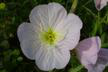

category 100000001


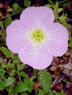

category 100000006


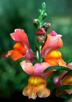

category 100000006


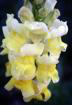

In [3]:
# show sample images
for i in [0, 1, 100, 101]:
    print('category %d' % y_train[i])
    img = Image.fromarray(X_train_raw[i])
    img.show()

In [4]:
num_classes = len(set(y_train))
print('number of unique classes:\t%d' % num_classes)

number of unique classes:	102


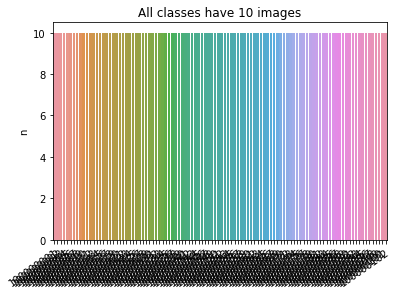

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

summary = pd.DataFrame.from_dict({y: y_train.count(y) for y in set(y_train)}, orient = 'index', columns = ['n'])
sns.barplot(data = summary, x = summary.index, y = 'n')
plt.xticks(rotation=35, ha='right', rotation_mode='anchor')
plt.rcParams['figure.figsize'] = [10, 5]
plt.title('All classes have 10 images')
plt.show()



In [6]:
# Encode output into dummy variables
import torch
from sklearn.preprocessing import OneHotEncoder

dummifyer = OneHotEncoder(sparse = False)
dummifyer.fit(np.array(y_train).reshape(-1, 1))
y_train_dummy = torch.from_numpy(dummifyer.transform(np.array(y_train).reshape(-1, 1)))
y_val_dummy = torch.from_numpy(dummifyer.transform(np.array(y_val).reshape(-1, 1)))

y_train_dummy[0:3]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [7]:
# preprocess images via PyTorch docs
from torchvision import transforms

def preprocess(X_raw, transformer_fn):
    X = []
    for img in X_raw:
        img_pil = Image.fromarray(img)
        proc_img = transformer_fn(img_pil)
        X.append(proc_img)
    return torch.stack(X)

In [8]:
transformer_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
X_train = preprocess(X_train_raw, transformer_fn)
X_val = preprocess(X_val_raw, transformer_fn)

Effect of preprocessing images above


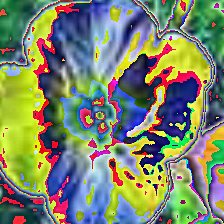

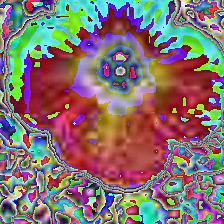

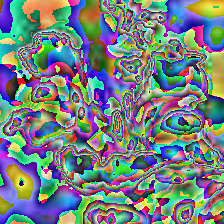

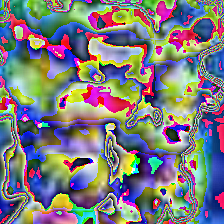

In [10]:
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

print("Effect of preprocessing images above")
for i in [0, 1, 100, 101]:
    img = to_img(X_train[i])
    img.show()

In [11]:
# load ResNet50
from torch import nn
from torchvision.models import resnet50 #resnet18

In [12]:
def get_resnet():
    resnet = resnet50(pretrained = True)
    # change the final fully connected layer output to the number of classes in the target dataset.
    resnet.fc = nn.Linear(2048, num_classes)
    return resnet

### (b) Fine tuning

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
# move data to GPU
torch.cuda.empty_cache()

X_train = X_train.to(device)
X_val = X_val.to(device)
y_train_dummy = y_train_dummy.to(device)
y_val_dummy = y_val_dummy.to(device)

print(X_train.is_cuda, y_train_dummy.is_cuda)

True True


In [15]:
# move model to GPU
resnet1 = get_resnet()
resnet1 = resnet1.to(device)

In [16]:
# set up training
from torch.optim.lr_scheduler import StepLR

# set the same value of hyperparameters (learning rate=0.001, momentum=0.9) for all the layers
decay_factor = 0.1
step_after_epochs = 60
momentum = 0.9
batch_size = 64


n_batches = int(np.ceil(len(X_train) / batch_size))
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train, y_train_dummy), batch_size = batch_size, shuffle = True)
val_loader = DataLoader(TensorDataset(X_val, y_val_dummy), batch_size = batch_size, shuffle = True)

In [18]:
# train loop

def train(model, tloader, vloader, lf, optim, lr_sch, step_size, epochs = 10):

    train_loss_history = []
    val_loss_history = []
    for t in range(epochs):

        epoch_train_loss = 0
        epoch_val_loss = 0
        model.train()
        for i, (X_local, y_local) in enumerate(tloader):

            # Forward pass: compute predicted y by passing x to the model.
            y_pred_local = model(X_local)

            # batch loss
            loss = lf(y_pred_local, y_local)
            epoch_train_loss += loss.item()
            #print("batch: %d/%d\tbatch loss: %.2f" % (i + 1, n_batches, loss.item()))

            # compute gradient
            optim.zero_grad()
            loss.backward()

            # update params
            optim.step()

        # show epoch train loss

        # get validation loss
        model.eval()
        for i, (X_local, y_local) in enumerate(vloader):

            # disable autograd
            with torch.no_grad():
                y_pred_local = model(X_local)

                # batch loss
                loss = lf(y_pred_local, y_local)
                epoch_val_loss += loss.item()

        # show epoch validation loss
        train_loss_history.append(epoch_train_loss)
        val_loss_history.append(epoch_val_loss)
        
        print("\t\t\t\tEpoch: %d/%d\tTrain loss: %.2f\tValid loss: %.2f" 
              % (t + 1, epochs, epoch_train_loss, epoch_val_loss))

        # increment lrate scheuler
        lr_sch.step()
        if t % step_size == step_size - 1:
            print("Learning Rate adjusted to: " + "{:.2e}".format(lr_sch.get_last_lr()[0]))
    
    return train_loss_history, val_loss_history

In [20]:
optimizer = torch.optim.SGD(resnet1.parameters(), lr = 0.001, momentum = momentum)
lr_scheduler = StepLR(optimizer, step_size = step_after_epochs, gamma = decay_factor)
                            
train_loss_history_lr1, val_loss_history_lr1 = train(
    model = resnet1,
    tloader =  train_loader,
    vloader = val_loader, 
    lf = loss_fn,
    optim = optimizer, 
    lr_sch = lr_scheduler,
    step_size = step_after_epochs, 
    epochs = 5)

				Epoch: 1/5	Train loss: 74.49	Valid loss: 73.38
				Epoch: 2/5	Train loss: 71.84	Valid loss: 71.36
				Epoch: 3/5	Train loss: 68.61	Valid loss: 69.00
				Epoch: 4/5	Train loss: 65.03	Valid loss: 66.51
				Epoch: 5/5	Train loss: 61.12	Valid loss: 63.51


In [21]:
def accuracy(model, X, y_true, encoder):
    correct = 0
    model.eval()
    for i in range(len(X)):
        with torch.no_grad():
            y_logits = model(X[[i],:])

        i = torch.argmax(y_logits).item()
        y_pred = encoder.categories_[0][i]
        
        if y_pred == y_true[i]:
            correct += 1
    return correct / len(y_true)

print("=" * 45 + "\nFinal Accuracy Report: lr_init = %.2e\n" % (0.001) + "=" * 45)
print("Training Accuracy:\t%.3f" % accuracy(resnet1, X_train, y_train, dummifyer))
print("Validation Accuracy:\t%.3f" % accuracy(resnet1, X_val, y_val, dummifyer))

Final Accuracy Report: lr_init = 1.00e-03
Training Accuracy:	0.073
Validation Accuracy:	0.070


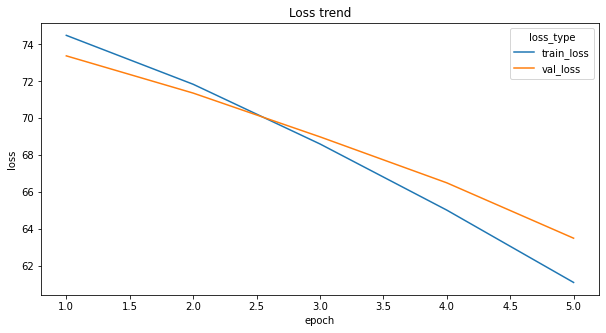

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss(train_loss_history, val_loss_history):
    results = pd.melt(
        pd.DataFrame({
            'epoch': np.arange(1, len(train_loss_history) + 1), 
            'train_loss': train_loss_history, 
            'val_loss': val_loss_history}),
        id_vars = ['epoch'], var_name = 'loss_type', value_name = 'loss')

    sns.lineplot(data = results, x = 'epoch', y = 'loss', hue = 'loss_type')
    plt.title('Loss trend')
    plt.show()
    
plot_loss(train_loss_history_lr1, val_loss_history_lr1)

In [24]:
resnet1.to('cpu')

resnet2 = get_resnet()
resnet2 = resnet2.to(device)

In [25]:
optimizer = torch.optim.SGD(resnet2.parameters(), lr = 0.01, momentum = momentum)
lr_scheduler = StepLR(optimizer, step_size = step_after_epochs, gamma = decay_factor)
                            
train_loss_history_lr2, val_loss_history_lr2 = train(
    model = resnet2,
    tloader =  train_loader,
    vloader = val_loader, 
    lf = loss_fn,
    optim = optimizer, 
    lr_sch = lr_scheduler,
    step_size = step_after_epochs, 
    epochs = 3)

				Epoch: 1/3	Train loss: 72.38	Valid loss: 62.45
				Epoch: 2/3	Train loss: 49.27	Valid loss: 37.82
				Epoch: 3/3	Train loss: 24.90	Valid loss: 27.33


In [26]:
print("=" * 45 + "\nFinal Accuracy Report: lr_init = %.2e\n" % (0.01) + "=" * 45)
print("Training Accuracy:\t%.3f" % accuracy(resnet2, X_train, y_train, dummifyer))
print("Validation Accuracy:\t%.3f" % accuracy(resnet2, X_val, y_val, dummifyer))

Final Accuracy Report: lr_init = 1.00e-02
Training Accuracy:	0.069
Validation Accuracy:	0.055


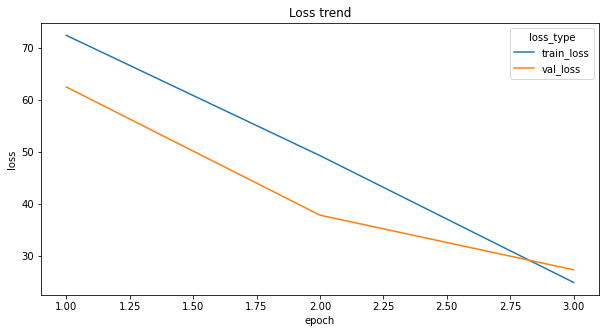

In [29]:
plot_loss(train_loss_history_lr2, val_loss_history_lr2)

In [30]:
resnet2.to('cpu')

resnet3 = get_resnet()
resnet3 = resnet3.to(device)

In [31]:
optimizer = torch.optim.SGD(resnet3.parameters(), lr = 0.1, momentum = momentum)
lr_scheduler = StepLR(optimizer, step_size = step_after_epochs, gamma = decay_factor)
                            
train_loss_history_lr3, val_loss_history_lr3 = train(
    model = resnet3,
    tloader =  train_loader,
    vloader = val_loader, 
    lf = loss_fn,
    optim = optimizer, 
    lr_sch = lr_scheduler,
    step_size = step_after_epochs, 
    epochs = 3)

				Epoch: 1/3	Train loss: 75.92	Valid loss: 1843046.84
				Epoch: 2/3	Train loss: 81.44	Valid loss: 63586633.00
				Epoch: 3/3	Train loss: 67.74	Valid loss: 58250.14


In [33]:
print("=" * 45 + "\nFinal Accuracy Report: lr_init = %.2e\n" % (0.1) + "=" * 45)
print("Training Accuracy:\t%.3f" % accuracy(resnet3, X_train, y_train, dummifyer))
print("Validation Accuracy:\t%.3f" % accuracy(resnet3, X_val, y_val, dummifyer))

Final Accuracy Report: lr_init = 1.00e-01
Training Accuracy:	0.000
Validation Accuracy:	0.000


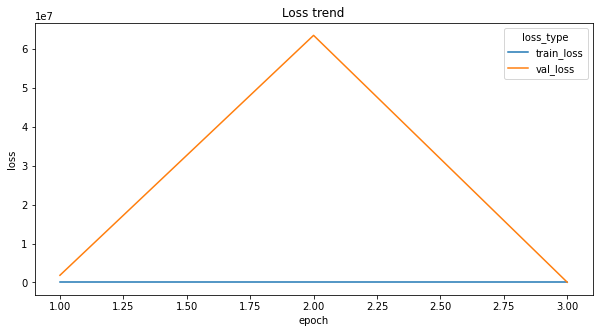

In [34]:
plot_loss(train_loss_history_lr3, val_loss_history_lr3)